# Notebook initialization:


In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [3.0,2.0]




import os 
path_to_class_sz = os.getcwd() + '/../../'

Metal device set to: Apple M1 Pro


2023-03-24 13:24:07.933961: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-24 13:24:07.934078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Settings

In [2]:

common_settings = {
                   'mass function' : 'T08', 
                   'hm_consistency': 0,
                   # 'concentration parameter': 'D08',  # Duffy et al 2008 
}


# copied from : https://github.com/simonsobs/websky_model/blob/a93bbf758432a936c0ec2b59775683b695d3d191/websky_model/websky.py#L55
websky_Omega_M = 0.31
websky_Omega_B = 0.049
websky_Omega_L = 0.69
websky_h = 0.68
websky_sigma_8 = 0.81
websky_n_s = 0.965


websky_cosmo = {
    'omega_b': websky_Omega_B*websky_h**2.,
    'omega_cdm': (websky_Omega_M-websky_Omega_B)*websky_h**2.,
    'h': websky_h,
    'tau_reio': 0.0543,
    'sigma8': websky_sigma_8,
    'n_s': websky_n_s, 
    'use_websky_m200m_to_m200c_conversion': 1,
    
    'use_redshift_dependent_M_min': 1,
    'full_path_to_redshift_dependent_M_min':path_to_class_sz+'class_sz_auxiliary_files/websky_halo_mass_completion_z_Mmin_in_Msun_over_h.txt',
    #'M_min' : 1e10*websky_cosmo['h'], # not used
    'M_max' : 1e16*websky_h,
    'z_min' : 5e-3,
    'z_max' : 4.6,
}

tsz_params ={

       'pressure profile': 'B12',  # check source/input.c for default parameter values of Battaglia et al profile (B12)
       'units for tSZ spectrum': 'dimensionless',
       'n_k_pressure_profile' : 100,
       'n_m_pressure_profile' : 100,
       'n_z_pressure_profile' : 100,
       'x_outSZ': 4.,
       'truncate_wrt_rvir':0,
       'pressure_profile_epsrel':1e-3,
       'pressure_profile_epsabs':1e-40,
        

}

# Compute

In [8]:
%%time 
M = Class()
M.set({'output':'tSZ_1h,tSZ_2h,kSZ_kSZ_tSZ_1h,kSZ_kSZ_tSZ_2h,kSZ_kSZ_tSZ_3h'})

M.set({
    
'dlogell' : 0.1, # increase to compute less ells for faster evaluation
'ell_max' : 10000.0,
'ell_min' : 2.0,    
'use_fft_for_profiles_transform' : 1, 
    
'bispectrum_lambda_2' :  1.,
'bispectrum_lambda_3' :  1.,
    
'gas profile' : 'B16', # set gas density profile
'gas profile mode' : 'agn',
'normalize_gas_density_profile' : 0,
'use_xout_in_density_profile_from_enclosed_mass' : 1,

'Frequency for y-distortion in GHz' : 143.
})

M.set(common_settings)
M.set(websky_cosmo)
M.set(tsz_params)


M.compute()

CPU times: user 6min 8s, sys: 680 ms, total: 6min 9s
Wall time: 39 s


In [9]:
cl_sz = M.cl_sz()
b_tty = M.b_tty()

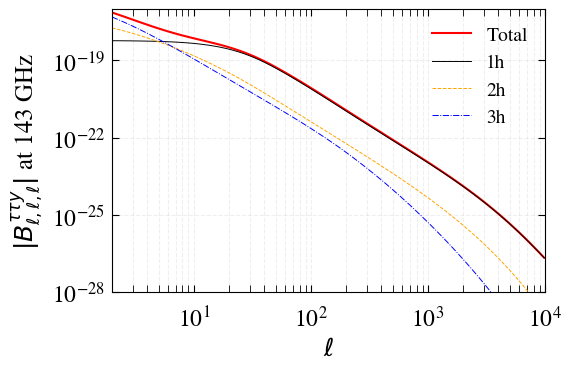

In [10]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(6,4))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')


ax.plot(b_tty['ell'],np.abs(np.asarray(b_tty['1h'])+np.asarray(b_tty['2h'])+np.asarray(b_tty['3h'])),label='Total',c='r')
ax.plot(b_tty['ell'],np.abs(np.asarray(b_tty['1h'])),label='1h',lw=0.7,ls='-',c='k')
ax.plot(b_tty['ell'],np.abs(np.asarray(b_tty['2h'])),label='2h',lw=0.7,ls='--',c='orange')
ax.plot(b_tty['ell'],np.abs(np.asarray(b_tty['3h'])),label='3h',lw=0.7,ls='-.',c='blue')

ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel('$\ell$',fontsize=18)
ax.set_ylabel(r'$|B_{\ell,\ell,\ell}^{\tau\tau y}|$ at 143 GHz',fontsize=18)
ax.legend(loc=1,ncol = 1,frameon=False,fontsize=14)

ax.set_xlim(2,1e4)
ax.set_ylim(1e-28,1e-17)

fig.tight_layout()
# fig.suptitle('Projected-field kSZ$^2$-Galaxy',fontsize=16)
fig.tight_layout()
plt.savefig('../../notebooks/class_sz_tutorial_notebooks/figures/class_sz_tty.pdf')

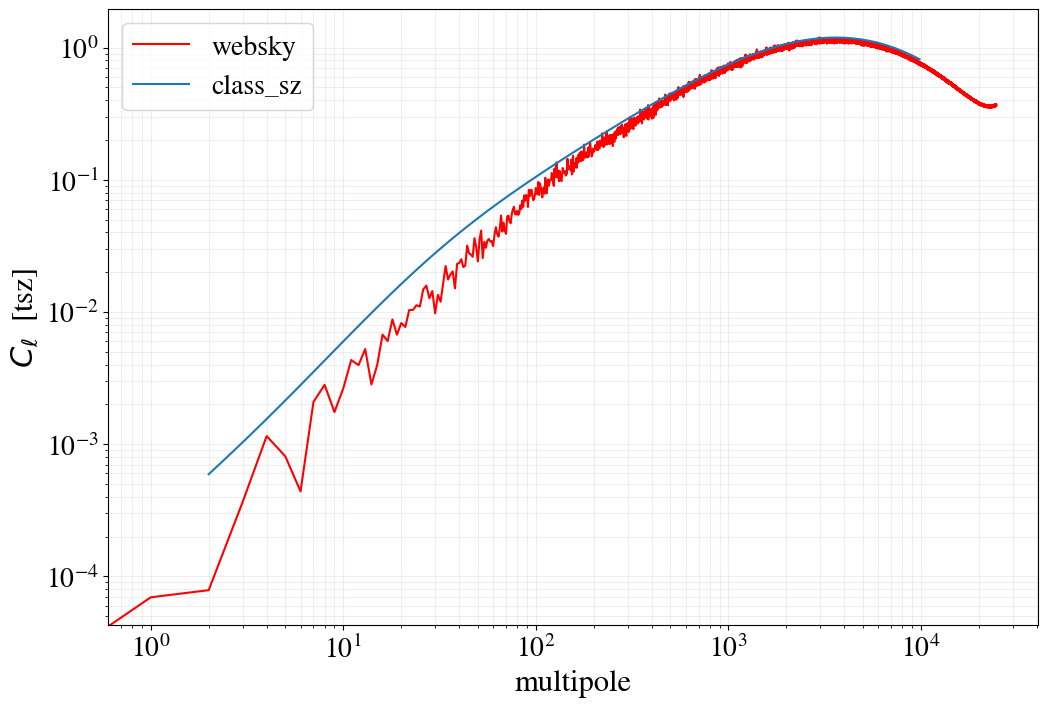

In [6]:
plt.figure(figsize=(12,8))

ls_ws,dls_ws = np.loadtxt(path_to_class_sz+'class_sz_auxiliary_files/websky_april_8192.txt',unpack=True)

plt.loglog(ls_ws,dls_ws*1e12,c='r',label='websky')
plt.loglog(cl_sz['ell'],np.asarray(cl_sz['1h'])+np.asarray(cl_sz['2h']),label='class_sz')

# plt.grid(which='both',alpha=0.2)
plt.loglog()
# plt.xlim(20,2e4)
# plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [tsz]',fontsize=22)
# plt.title('353x353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)